In [0]:
# The essentials
import pandas as pd
import numpy as np

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Access our Google Drive
from google.colab import drive

In [2]:
drive.mount('/content/drive', force_remount=True)
!ls "/content/drive/My Drive/Rinse Over Run"

Mounted at /content/drive
20178.png
20451.png
20899.png
22112.png
22369.png
22414.png
22487.png
23011.png
23142.png
23599.png
23872.png
24804.png
24845.png
24872.png
25129.png
25908.png
25983.png
26270.png
27115.png
27243.png
27346.png
27366.png
27418.png
27508.png
all_train_preds_per_phase.p
baseline_features_with_preds_per_phase.csv
baseline_model_per_nunique_phases.csv
dtw_distances_3.p
extended_phase_predictors.csv
last_cleaned_test.csv
last_cleaned_train.csv
mds_embeddings_2d_3.csv
mds_embeddings_2d_3.p
model_per_recipe_simple.csv
more_features_with_preds_per_phase.csv
pca_features_with_preds_per_phase.csv
predictions_machine_405.csv
preds_feature_selection.csv
processes_all_phases.p
process_machine_outlier_predicted.csv
recipe_metadata.csv
recipe_model_prev_process_tsfresh.csv
test_features_14.csv
test_features_15.csv
test_features_1.csv
test_features_2.csv
test_features_3.csv
test_features_6.csv
test_features_7.csv
test_features_8.csv
test_features_per_phase_14.csv
test_features

In [3]:
train_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_values.csv', index_col=0, parse_dates=['timestamp'])
test_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_values.csv', index_col=0, parse_dates=['timestamp'])
label_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_labels.csv', index_col='process_id')

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [40]:
train_df = train_df[train_df['phase'] != 'final_rinse']

train_df['phase_int'] = train_df['phase'].map({'pre_rinse': 1, 
                                               'caustic': 2, 
                                               'intermediate_rinse': 4, 
                                               'acid': 8})
test_df['phase_int'] = test_df['phase'].map({'pre_rinse': 1, 
                                             'caustic': 2, 
                                             'intermediate_rinse': 4, 
                                             'acid': 8})
train_process_combinations = pd.DataFrame(train_df.groupby('process_id')['phase_int'].unique().apply(lambda x: sum(x)))
train_process_combinations = train_process_combinations.merge(train_df[['process_id', 'pipeline']].drop_duplicates().set_index('process_id', drop=True), left_index=True, right_index=True)
test_process_combinations = pd.DataFrame(test_df.groupby('process_id')['phase_int'].unique().apply(lambda x: sum(x)))
test_process_combinations = test_process_combinations.merge(test_df[['process_id', 'pipeline']].drop_duplicates().set_index('process_id', drop=True), left_index=True, right_index=True)
process_combinations = pd.concat([train_process_combinations, test_process_combinations], axis=0)
process_combinations.head(10)

,phase_int,pipeline
process_id,,
20001,15,L4
20002,3,L3
20003,15,L3
20004,15,L7
20005,8,L7
20008,15,L4
20011,15,L4
20014,15,L8
20016,15,L1


In [0]:
recipe_df = pd.read_csv('/content/drive/My Drive/Rinse Over Run/recipe_metadata.csv', index_col='process_id')

In [0]:
recipe_df = recipe_df.drop('final_rinse', axis=1)
recipe_df['pre_rinse'] *= 1
recipe_df['caustic'] *= 2
recipe_df['intermediate_rinse'] *= 4
recipe_df['acid'] *= 8
recipe_df['sum'] = recipe_df['pre_rinse'] + recipe_df['caustic'] + recipe_df['intermediate_rinse'] + recipe_df['acid']

train_procs = list(set(train_df['process_id']))
test_procs = list(set(test_df['process_id']))

In [7]:
recipe_df.loc[train_procs].groupby('sum').count()

,pre_rinse,caustic,intermediate_rinse,acid
sum,,,,
3,1050,1050,1050,1050
9,193,193,193,193
15,3762,3762,3762,3762


In [8]:
recipe_df.loc[test_procs].groupby('sum').count()

,pre_rinse,caustic,intermediate_rinse,acid
sum,,,,
3,587,587,587,587
9,122,122,122,122
15,2258,2258,2258,2258


In [30]:
recipe_df[['sum']].merge(train_process_combinations[['phase_int']], left_index=True, right_index=True).groupby('sum')['phase_int'].value_counts()

sum  phase_int
3    3            1012
     2              38
9    8             193
15   15           3726
     14             22
     8               6
     3               5
     1               3
Name: phase_int, dtype: int64

In [43]:
recipe_df[['sum']].merge(train_process_combinations[['phase_int', 'pipeline']], left_index=True, right_index=True).groupby(['sum', 'phase_int'])['pipeline'].value_counts()

sum  phase_int  pipeline
3    2          L3           36
                L2            2
     3          L2          414
                L3          255
                L6          201
                L8          116
                L4           11
                L1            9
                L12           3
                L10           2
                L7            1
9    8          L9           65
                L11          55
                L7           50
                L8            8
                L3            6
                L1            4
                L10           3
                L4            2
15   1          L10           1
                L11           1
                L9            1
     3          L3            3
                L2            1
                L8            1
     8          L7            2
                L9            2
                L4            1
                L8            1
     14         L3           12
               

In [44]:
recipe_df[['sum']].merge(test_process_combinations[['phase_int', 'pipeline']], left_index=True, right_index=True).groupby(['sum', 'phase_int'])['pipeline'].value_counts()

sum  phase_int  pipeline
3    1          L2           28
                L3           18
                L6           13
                L8            4
                L1            1
                L10           1
     2          L3           19
     3          L2          196
                L6          127
                L3          118
                L8           45
                L1            8
                L4            6
                L10           3
9    8          L11          34
                L9           32
                L7           31
                L8            8
                L10           5
                L4            5
                L6            4
                L2            3
15   1          L4           42
                L1           40
                L8           36
                L9           29
                L7           27
                L10          21
                L3           20
                L2           10
               

In [25]:
len(recipe_df)

7988

In [28]:
len(set(train_df['process_id']))

5005

In [39]:
set(recipe_df[['sum']].merge(train_process_combinations[['phase_int', 'pipeline']], left_index=True, right_index=True)['pipeline'])

{'L1', 'L10', 'L3'}

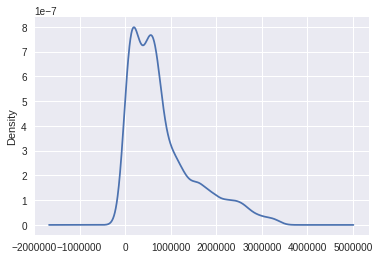

In [58]:
labels = label_df['final_rinse_total_turbidity_liter']
labels_perc5 = np.percentile(labels, 5)
labels_perc90 = np.percentile(labels, 85)
pd.Series(labels[(labels <= labels_perc90)]).plot(kind='kde')